In [1]:
import sys
sys.path.append('../src/')
from vi_hrg import *
from utils import c2d, hyperdist, p_hd, polar2cart
from distributions.von_mises_fisher import VonMisesFisher

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
loc = torch.tensor([0.,0.])
scale = torch.tensor([0.1])
dist = svae.VonMisesFisher(loc, scale)
samples = dist.rsample(10000)

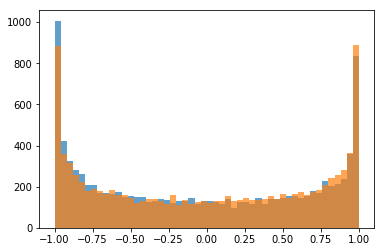

In [4]:
alpha = 0.7
bins=50
plt.hist(samples[:,0], alpha=alpha, bins=bins)
plt.hist(samples[:,1], alpha=alpha, bins=bins)
plt.show()

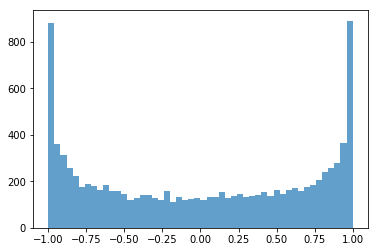

In [5]:
plt.hist(samples[:,1], alpha=alpha, bins=bins)
plt.show()

In [6]:
from torch.distributions.normal import Normal

In [11]:
loc = torch.tensor([-np.pi*1.5])
scale = torch.tensor([1.5])
norm = Normal(loc=loc, scale=scale)
circle_transform = lambda m,x: (x)%(2*np.pi) 
phi = circle_transform(loc,norm.rsample([10000]))

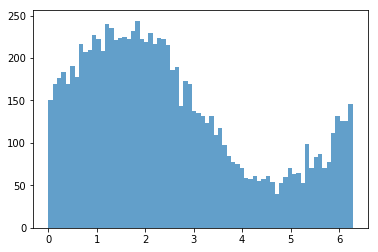

In [12]:
alpha = 0.7
bins=70
plt.hist(phi.flatten(), alpha=alpha, bins=bins)
plt.show()

In [37]:
import math
import torch
from torch.distributions.kl import register_kl

#from hyperspherical_vae.ops.ive import ive
#from hyperspherical_vae.distributions.hyperspherical_uniform import HypersphericalUniform


class VonMisesFisher(torch.distributions.Distribution):

    arg_constraints = {'loc': torch.distributions.constraints.real,
                       'scale': torch.distributions.constraints.positive}
    support = torch.distributions.constraints.real
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        return self.loc * (ive(self.__m / 2, self.scale) / ive(self.__m / 2 - 1, self.scale))

    @property
    def stddev(self):
        return self.scale

    def __init__(self, loc, scale, validate_args=None):
        self.dtype = loc.dtype
        self.loc = loc
        self.scale = scale
        self.device = loc.device
        self.__m = loc.shape[-1]
        self.__e1 = (torch.Tensor([1.] + [0] * (loc.shape[-1] - 1))).to(self.device)

        super(VonMisesFisher, self).__init__(self.loc.size(), validate_args=validate_args)

    def sample(self, shape=torch.Size()):
        with torch.no_grad():
            return self.rsample(shape)

    def rsample(self, shape=torch.Size()):
        shape = shape if isinstance(shape, torch.Size) else torch.Size([shape])

        w = self.__sample_w3(shape=shape) if self.__m == 3 else self.__sample_w_rej(shape=shape)

        v = (torch.distributions.Normal(0, 1).sample(
            shape + torch.Size(self.loc.shape)).to(self.device).transpose(0, -1)[1:]).transpose(0, -1)
        v = v / v.norm(dim=-1, keepdim=True)

        w_ = torch.sqrt(torch.clamp(1 - (w ** 2), 1e-10))
        x = torch.cat((w, w_ * v), -1)
        z = self.__householder_rotation(x)

        return z.type(self.dtype) # no rotation

    def __sample_w3(self, shape):
        shape = shape + torch.Size(self.scale.shape)
        u = torch.distributions.Uniform(0, 1).sample(shape).to(self.device)
        self.__w = 1 + torch.stack([torch.log(u), torch.log(1 - u) - 2 * self.scale], dim=0).logsumexp(0) / self.scale
        return self.__w

    def __sample_w_rej(self, shape):
        c = torch.sqrt((4 * (self.scale ** 2)) + (self.__m - 1) ** 2)
        b_true = (-2 * self.scale + c) / (self.__m - 1)

        # using Taylor approximation with a smooth swift from 10 < scale < 11
        # to avoid numerical errors for large scale
        b_app = (self.__m - 1) / (4 * self.scale)
        s = torch.min(torch.max(torch.tensor([0.], device=self.device),
                                self.scale - 10), torch.tensor([1.], device=self.device))
        b = b_app * s + b_true * (1 - s)

        a = (self.__m - 1 + 2 * self.scale + c) / 4
        d = (4 * a * b) / (1 + b) - (self.__m - 1) * math.log(self.__m - 1)

        self.__b, (self.__e, self.__w) = b, self.__while_loop(b, a, d, shape)
        return self.__w

    def __while_loop(self, b, a, d, shape):

        b, a, d = [e.repeat(*shape, *([1] * len(self.scale.shape))) for e in (b, a, d)]
        w, e, bool_mask = torch.zeros_like(b).to(self.device), torch.zeros_like(
            b).to(self.device), (torch.ones_like(b) == 1).to(self.device)

        shape = shape + torch.Size(self.scale.shape)

        while bool_mask.sum() != 0:
            e_ = torch.distributions.Beta((self.__m - 1) / 2, (self.__m - 1) /
                                          2).sample(shape[:-1]).reshape(shape).to(self.device)
            u = torch.distributions.Uniform(0, 1).sample(shape).to(self.device)

            w_ = (1 - (1 + b) * e_) / (1 - (1 - b) * e_)
            t = (2 * a * b) / (1 - (1 - b) * e_)

            accept = ((self.__m - 1) * t.log() - t + d) > torch.log(u)
            reject = ~accept if torch.__version__ >= "1.2.0" else 1 - accept

            w[bool_mask * accept] = w_[bool_mask * accept]
            e[bool_mask * accept] = e_[bool_mask * accept]

            bool_mask[bool_mask * accept] = reject[bool_mask * accept]

        return e, w

    def __householder_rotation(self, x):
        u = (self.__e1 - self.loc)
        u = u / (u.norm(dim=-1, keepdim=True) + 1e-5)
        z = x - 2 * (x * u).sum(-1, keepdim=True) * u
        return z

    def entropy(self):
        output = - self.scale * ive(self.__m / 2, self.scale) / ive((self.__m / 2) - 1, self.scale)

        return output.view(*(output.shape[:-1])) + self._log_normalization()

    def log_prob(self, x):
        return self._log_unnormalized_prob(x) - self._log_normalization()

    def _log_unnormalized_prob(self, x):
        output = self.scale * (self.loc * x).sum(-1, keepdim=True)
        print(output)
        return output.view(*(output.shape[:-1]))

    def _log_normalization(self):
        output = - ((self.__m / 2 - 1) * torch.log(self.scale) - (self.__m / 2) * math.log(2 * math.pi) - (
            self.scale + torch.log(ive(self.__m / 2 - 1, self.scale))))
        print(output)
        return output.view(*(output.shape[:-1]))


#@register_kl(VonMisesFisher, HypersphericalUniform)
#def _kl_vmf_uniform(vmf, hyu):
#    return - vmf.entropy() + hyu.entropy()

import numpy as np
import scipy.special
from numbers import Number

class IveFunction(torch.autograd.Function):

    @staticmethod
    def forward(self, v, z):
        
        assert isinstance(v, Number), 'v must be a scalar'
        
        self.save_for_backward(z)
        self.v = v
        z_cpu = z.data.cpu().numpy()
        
        if np.isclose(v, 0):
            output = scipy.special.i0e(z_cpu, dtype=z_cpu.dtype)
        elif np.isclose(v, 1):
            output = scipy.special.i1e(z_cpu, dtype=z_cpu.dtype)
        else: #  v > 0
            output = scipy.special.ive(v, z_cpu, dtype=z_cpu.dtype)
#         else:
#             print(v, type(v), np.isclose(v, 0))
#             raise RuntimeError('v must be >= 0, it is {}'.format(v))
        
        return torch.Tensor(output).to(z.device)

    @staticmethod
    def backward(self, grad_output):
        z = self.saved_tensors[-1]
        return None, grad_output * (ive(self.v - 1, z) - ive(self.v, z) * (self.v + z) / z)

class Ive(torch.nn.Module):
    
    def __init__(self, v):
        super(Ive, self).__init__()
        self.v = v
        
    def forward(self, z):
        return ive(self.v, z)

ive = IveFunction.apply

In [5]:
def cart2polar(x, y):
    """
    Transform Cartesian coordinates to polar.
    Parameters
    ----------
    x, y : floats or arrays
        Cartesian coordinates
    Returns
    -------
    r, theta : floats or arrays
        Polar coordinates
    """
    r = torch.sqrt(x**2 + y**2)
    theta = torch.atan2(y,x)  # θ referenced to vertical
    return r, theta

def p2c(r, phi):
    return torch.stack((r * phi.cos(), r * phi.sin()), dim=-1).squeeze()

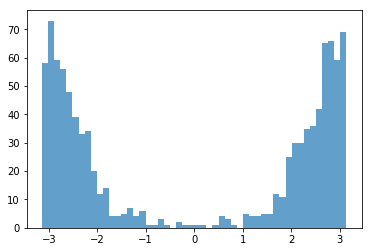

In [14]:
loc = torch.tensor([1., 1., 0.])
loc_r, loc_phi = torch.tensor([1.]), torch.tensor([np.pi])
scale = torch.tensor([2.])
dist = VonMisesFisher(p2c(loc_r, loc_phi), scale)
samples = dist.rsample(1000)
alpha = 0.7
bins=50
r, theta = cart2polar(samples[:,0], samples[:,1])
plt.hist(theta, alpha=alpha, bins=bins)
#plt.hist(samples[:,1], alpha=alpha, bins=bins)
#plt.hist(samples[:,2], alpha=alpha, bins=bins)
plt.show()

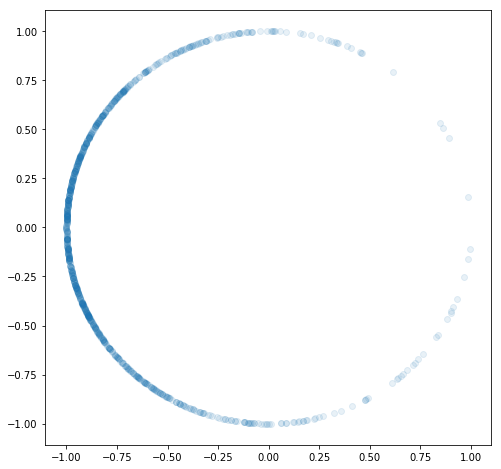

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1], alpha=0.1)
plt.show()

In [40]:
p2c(loc_r, loc_phi)

tensor([-1.0000e+00, -8.7423e-08])

In [48]:
dist.sample(10)

tensor([[-0.1617,  0.9868],
        [-0.5290, -0.8486],
        [-0.9351, -0.3545],
        [-0.4789,  0.8779],
        [-0.8857, -0.4642],
        [ 0.1606, -0.9870],
        [-0.7026,  0.7115],
        [-0.9994,  0.0336],
        [-0.6625, -0.7491],
        [-0.9748, -0.2232]])

In [50]:
dist.log_prob(dist.sample(torch.Size([10])))

tensor([[ 1.9828],
        [ 1.9223],
        [ 1.8412],
        [ 1.5795],
        [ 1.3006],
        [ 1.9092],
        [ 1.9550],
        [ 1.9241],
        [ 1.9665],
        [-0.0870]])
tensor([2.6619])


TypeError: view() missing 1 required positional arguments: "size"

In [44]:
torch.tensor([[1., 0.]]).shape[:-1]

torch.Size([1])

In [218]:
loc_r, loc_phi = torch.tensor([1.,1.]), torch.tensor([0., np.pi])
p2c(loc_r, loc_phi)

tensor([[ 1.0000e+00,  0.0000e+00],
        [-1.0000e+00, -8.7423e-08]])

In [129]:
len(loc.shape)

1

In [273]:
phi_i = 10
phi_j = torch.arange(-10.,10., 0.05)
x = phi_i-phi_j

In [274]:
potsdam = x.cos()
wiki = (np.pi - (x.abs() - np.pi).abs()).cos()
sum(wiki - potsdam)

tensor(-2.2945e-05)

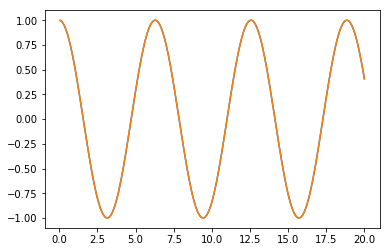

In [275]:
plt.plot(x.numpy(), potsdam.numpy())
plt.plot(x.numpy(), wiki.numpy())

In [51]:
torch.__version__

'1.1.0'